# Using NP4VTT: Klein-Spady model

In this notebook, we show how to use a Klein-Spady estimator to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the Klein-Spady, and Pandas to load the dataset:

In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
import numpy as np
import py_np4vtt
from py_np4vtt.data_format import StudyVar
from py_np4vtt.model_kspady import ModelKSpady, ConfigKSpady
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [3]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL`: Travel cost of alternatives 1 [NOK]
* `CostR`: Travel cost of alternatives 2 [NOK]
* `TimeL`: Travel time of alternatives 1 [minutes]
* `TimeR`: Travel time of alternatives 2 [minutes]

NP4VTT detects automatically the _slow and cheap_ and _fast and expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Change currency of travel time to euros and change unit of travel time to hours

In [4]:
# Convert to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

# convert to hours
df[['TimeL','TimeR']] = df[['TimeL','TimeR']] .div(60)

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [5]:
columnarrays = {
    StudyVar.Id: 'RespID',
    StudyVar.ChosenAlt: 'Chosen',
    StudyVar.Cost1: 'CostL',
    StudyVar.Cost2: 'CostR',
    StudyVar.Time1: 'TimeL',
    StudyVar.Time2: 'TimeR',
}

And we create the required arrays:

In [6]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [7]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 3.5800867802855794
Minimum of BVTT: 0.6666666666666644
Maximum of BVTT: 113.56321839080461


## Step 3: Configure the Klein-Spady

The Klein-Spady requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.

The function `ConfigLocLogit` takes the configuration parameters of the Klein-Spady and creates an object that is used by the optimisation routine:

In [8]:
config = ConfigKSpady(minimum=0, maximum=100, supportPoints=26)

Now, we create the Klein-Spady object that contains the configuration parameters and the data arrays. Then, we initialise the arguments:

In [9]:
ks = ModelKSpady(config, model_arrays)
initialArgs = ks.setupInitialArgs()

## Step 4: Estimate a Klein-Spady estimator

Once the Klein-Spady object is initialised, the `run` method starts the optimisation process:

In [10]:
p, vtt_grid = ks.run(initialArgs)

The estimated model returns the following information:

* `p:` The cumulative probability of each point of the VTT grid.
* `fval:` Value of the likelihood function in the optimum.
* `vtt_grid:` The VTT grid

The following lines present the estimated results:

In [11]:
import numpy as np

# Create dataframe
results = pd.Series(p,name='Cum. Prob.',index=vtt_grid.astype(int))

print('Estimation results:\n')
# print('Final log-likelihood: ' + str(round(fval,2)))
print('\nEstimated Cumulative probability:')
print(results)

Estimation results:


Estimated Cumulative probability:
0      0.319879
4      0.396986
8      0.499219
12     0.613046
16     0.718610
20     0.787333
24     0.821959
28     0.842564
32     0.861505
36     0.883549
40     0.901996
44     0.911639
48     0.918149
52     0.925134
56     0.928799
60     0.926146
64     0.922969
68     0.924974
72     0.932482
76     0.944782
80     0.951292
84     0.947855
88     0.937909
92     0.934562
96     0.947642
100    0.966047
Name: Cum. Prob., dtype: float64


## Step 5: Visualising the VTT distribution

We create the empirical Cumulative Density Function plot of the VTT distribution. For easy interpretation, we use create a histogram from the CDF. 
We use matplotlib for this:

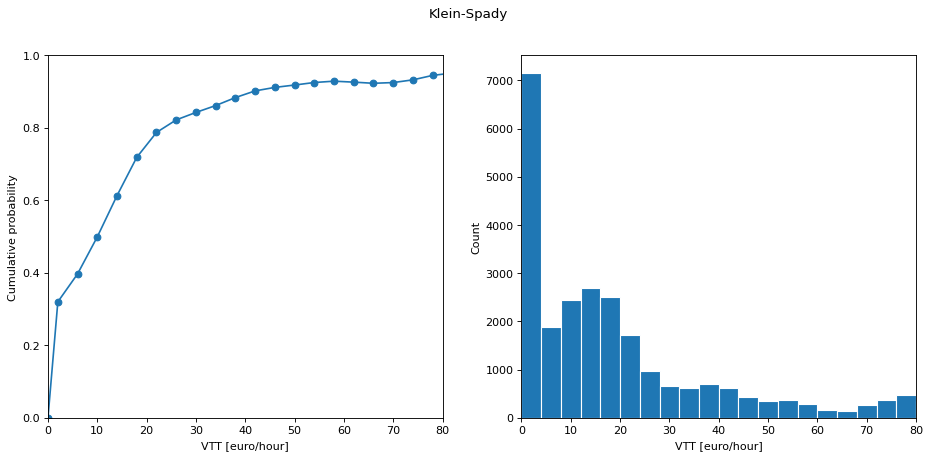

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain the midpoints from the vtt_grid
vtt_grid_midpoints = ((np.append(vtt_grid, 0) + np.append(0,vtt_grid)))/2
vtt_grid_midpoints[-1] = vtt_grid[-1]

fig, ax = plt.subplots(1,2,figsize=(14,6), dpi=80)

# Plot CDF
ax[0].plot(vtt_grid_midpoints,np.concatenate((0,p),axis=None),marker='o')
ax[0].set_xlim(0,80)
ax[0].set_ylim(0,1)
ax[0].set_xlabel('VTT [euro/hour]')
ax[0].set_ylabel('Cumulative probability')


# Obtain probabilities from the CDF plot
pp = ((np.append(p, 0)-np.append(0,p)))
pp = pp + np.abs(np.min(pp[:-1]))
pp = (np.divide(pp,np.sum(pp)))
pp[-1] = 0
pp = np.append(0,pp)

# Construct data points
data_hist = []
for n in range(0,len(vtt_grid_midpoints)):
    dat = [vtt_grid_midpoints[n]]*np.round((pp[n]*descriptives.NP)).astype(int)
    data_hist = np.append(data_hist,dat)

# Plot histogram
ax[1].set_xlim(0,80)
ax[1].set_xlabel('VTT [euro/hour]')
ax[1].set_ylabel('Count')
ax[1].hist(data_hist, bins = vtt_grid,edgecolor="white")
fig.suptitle('Klein-Spady')
plt.show()